In [1]:
%matplotlib inline
import torch
from torch import nn
import torchvision
import d2l.torch as d2l
import os

In [3]:
d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip',
                         'fba480ffa8aa7e0febbb511d181409f899b9baa5')
data_dir=d2l.download_extract('hotdog')

#ImageFolder使用：https://www.cnblogs.com/wanghui-garcia/p/10649364.html

In [4]:
train_imgs=torchvision.datasets.ImageFolder(os.path.join(data_dir,'train'))

test_imgs=torchvision.datasets.ImageFolder(os.path.join(data_dir,'test'))

In [5]:
print(type(train_imgs))

<class 'torchvision.datasets.folder.ImageFolder'>


In [6]:
len(train_imgs)

2000

In [7]:
len(train_imgs[1])

2

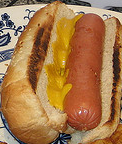

In [16]:
train_imgs[0][0]

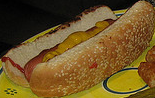

In [18]:
train_imgs[1][0]

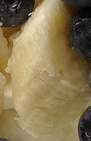

In [19]:
train_imgs[-1][0]

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

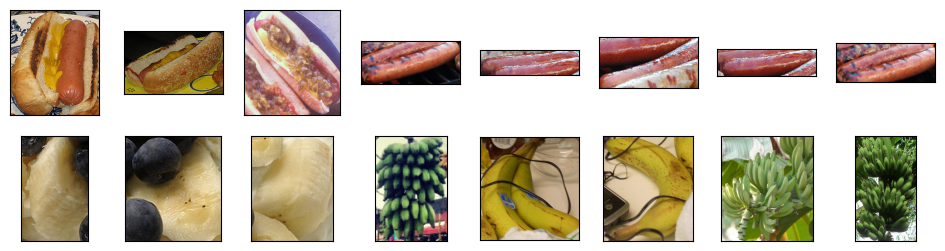

In [22]:
hotdogs=[train_imgs[i][0] for i in range(8)]
not_hotdogs=[train_imgs[-i-1][0] for i in range(8)]
d2l.show_images(hotdogs+not_hotdogs,2,8,scale=1.5)

In [23]:
# 使用RGB通道的均值和标准差，以标准化每个通道
normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [24]:
#图像增广
train_augs=torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    normalize
])

test_augs=torchvision.transforms.Compose({
    torchvision.transforms.Resize([256,256]),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize
})

In [25]:
pretrained_net=torchvision.models.resnet18(pretrained=True)


d:\Python\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Python\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\56283/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:06<00:00, 7.03MB/s]


In [26]:
pretrained_net.fc

Linear(in_features=512, out_features=1000, bias=True)

In [29]:
finetune_net=torchvision.models.resnet18(pretrained=True)
finetune_net.fc=nn.Linear(finetune_net.fc.in_features,2)
nn.init.xavier_uniform_(finetune_net.fc.weight)

d:\Python\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Python\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Parameter containing:
tensor([[ 0.0571, -0.0224, -0.0337,  ..., -0.0278, -0.1329, -0.0049],
        [ 0.0732,  0.0542,  0.0811,  ..., -0.0189,  0.0267, -0.0484]],
       requires_grad=True)

In [33]:
def train_fine_tuning(net,learning_rate,batch_size=128,num_epoch=5,param_group=True):
    train_iter=torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder(root=os.path.join(data_dir,'train'),transform=train_augs),
        batch_size=batch_size,shuffle=True)
    test_iter=torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder(root=os.path.join(data_dir,'test'),transform=test_augs),
        batch_size=batch_size)
    devices=d2l.try_all_gpus()
    loss=nn.CrossEntropyLoss(reduction='none')
    if param_group:
        params_1x=[param for name,param in net.named_parameters() if name not in ["fc.weight","fc.bias"]]
        trainer=torch.optim.SGD([{'params':params_1x},{'params':net.fc.parameters(),'lr':learning_rate*10}],
                                lr=learning_rate,weight_decay=0.001)
        
    else:
        trainer=torch.optim.SGD(net.parameters(),lr=learning_rate,weight_decay=0.001)
    
    d2l.train_ch13(net,train_iter,test_iter,loss,trainer,num_epoch,devices)


KeyboardInterrupt: 

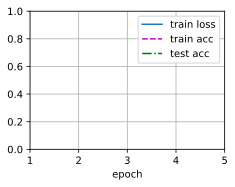

In [34]:
train_fine_tuning(finetune_net,5e-5)

In [ ]:
scratch_net = torchvision.models.resnet18()
scratch_net.fc = nn.Linear(scratch_net.fc.in_features, 2)
train_fine_tuning(scratch_net, 5e-4, param_group=False)